<a href="https://colab.research.google.com/github/pankaj09318/Concept-and-technologies-of-AI-Assessment/blob/main/FinalPortfolio_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# ==========================================
# 1. Imports & Data Loading
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time  # <--- Added for tracking training time

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor          # <--- Model 1
from sklearn.ensemble import RandomForestRegressor      # <--- Model 2
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# ---------------------------------------------------------
# TODO: Replace with your actual file path
file_path = '/content/drive/MyDrive/IHME-GBD_2023_DATA-f7d074ec-1.csv'
# ---------------------------------------------------------

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")


Dataset loaded successfully.
Shape: (88968, 18)


In [11]:
# ==========================================
# 2. Data Cleaning & Target Engineering
# ==========================================

# 2.1 Drop Leakage/Irrelevant Columns
# We remove 'upper' and 'lower' because they are derived from the target 'val' (Data Leakage).
cols_to_drop = [
    'upper', 'lower', 'population_group_id', 'population_group_name',
    'measure_id', 'measure_name', 'metric_id', 'metric_name',
    'location_id', 'sex_id', 'age_id', 'cause_id'
]
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# 2.2 Handle Missing Values
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    else:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

# The target for Regression is 'val' (continuous number)
target = 'val'
print(f"Data Cleaned. Target Variable: '{target}'")


Data Cleaned. Target Variable: 'val'


Converting categorical columns to numbers for Heatmap...
 - Encoded location_name
 - Encoded sex_name
 - Encoded age_name
 - Encoded cause_name


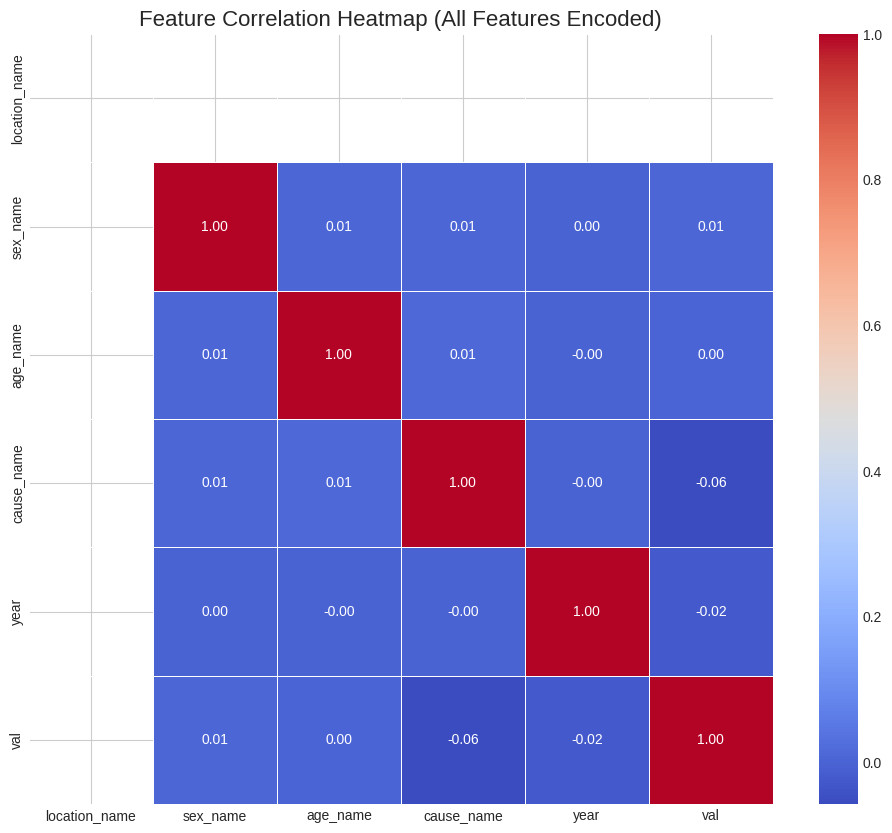

In [12]:
# ==========================================
# 3. Correlation Heatmap (Categorical Handled)
# ==========================================

# Rationale: The tutor requested to "remove categorical data" issues before plotting.
# We create a COPY of the data and convert ALL text columns to Numbers (Label Encoding).
# This allows the Heatmap to process them mathematically.

df_heatmap = df_clean.copy()
le = LabelEncoder()

print("Converting categorical columns to numbers for Heatmap...")
for col in df_heatmap.select_dtypes(include='object').columns:
    df_heatmap[col] = le.fit_transform(df_heatmap[col].astype(str))
    print(f" - Encoded {col}")

plt.figure(figsize=(12, 10))
# Compute correlation matrix
corr_matrix = df_heatmap.corr()

# Draw Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap (All Features Encoded)', fontsize=16)
plt.show()


In [13]:
# ==========================================
# 4. Preprocessing & Splitting
# ==========================================

# 4.1 Define Features (X) and Target (y)
X = df_clean.drop(target, axis=1)
y = df_clean[target]

# 4.2 One-Hot Encoding
# We use One-Hot Encoding for modeling (better than Label Encoding for Neural Nets/Linear models)
X_encoded = pd.get_dummies(X, drop_first=True)

# 4.3 Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 4.4 Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale Target (y) - Required for Neural Network convergence
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()

print(f"Final Training Data Shape: {X_train_scaled.shape}")


Final Training Data Shape: (71174, 72)


Training Neural Network...
Training Completed in 59.0946 seconds
RMSE: 206.4266
R2 Score: 0.9981


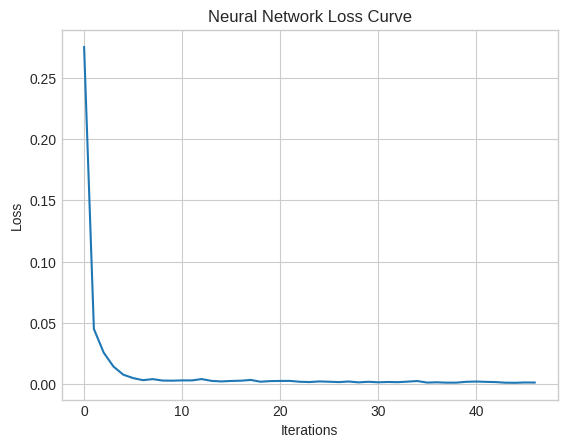

In [14]:
# ==========================================
# 5. Task 1: Neural Network (Regression)
# ==========================================

mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)

print("Training Neural Network...")
start_time = time.time()  # Start Timer
mlp.fit(X_train_scaled, y_train_scaled) # Training on Scaled Target
end_time = time.time()    # End Timer

nn_time = end_time - start_time

# Predict (Inverse Transform to get real values)
y_pred_nn_scaled = mlp.predict(X_test_scaled)
y_pred_nn = y_scaler.inverse_transform(y_pred_nn_scaled.reshape(-1, 1)).ravel()

# Metrics
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
nn_r2 = r2_score(y_test, y_pred_nn)

print(f"Training Completed in {nn_time:.4f} seconds")
print(f"RMSE: {nn_rmse:.4f}")
print(f"R2 Score: {nn_r2:.4f}")

# Plot Loss Curve
plt.plot(mlp.loss_curve_)
plt.title("Neural Network Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


In [15]:
# ==========================================
# 6. Task 2: Classical Models (Decision Tree & Random Forest)
# ==========================================

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")

    start_time = time.time() # Start Timer
    model.fit(X_train_scaled, y_train) # Train on original target (unscaled)
    end_time = time.time()   # End Timer

    train_time = end_time - start_time
    y_pred = model.predict(X_test_scaled)

    # Calculate Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "R2 Score": r2,
        "Time (sec)": train_time
    })
    print(f" - Done in {train_time:.4f}s | R2: {r2:.4f}")

# Add Neural Network to results for comparison
results.append({
    "Model": "Neural Network",
    "RMSE": nn_rmse,
    "R2 Score": nn_r2,
    "Time (sec)": nn_time
})

pd.DataFrame(results)


Training Decision Tree...
 - Done in 1.0314s | R2: 0.9994
Training Random Forest...
 - Done in 82.2427s | R2: 0.9993


,Model,RMSE,R2 Score,Time (sec)
0,Decision Tree,120.413177,0.999357,1.031419
1,Random Forest,123.812437,0.999321,82.242744
2,Neural Network,206.426596,0.998111,59.094587


In [16]:
# ==========================================
# 7. Hyperparameter Optimization
# ==========================================

# --- A. Tune Decision Tree ---
param_grid_dt = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 20]
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=3, scoring='r2', n_jobs=1)

print("Tuning Decision Tree...")
start = time.time()
grid_dt.fit(X_train_scaled, y_train)
best_dt_params = grid_dt.best_params_
print(f"Best Decision Tree Params: {best_dt_params}")

# --- B. Tune Random Forest (FIXED) ---
# Reduced complexity to avoid memory crash
param_grid_rf = {
    'n_estimators': [50],         # Reduced from [50, 100] to save memory
    'max_depth': [10, 20],        # Capped depth
    'min_samples_split': [5]      # Fixed split size
}

# n_jobs=1 prevents parallel workers from crashing memory
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=1)

print("Tuning Random Forest ")
start = time.time()
grid_rf.fit(X_train_scaled, y_train)
best_rf_params = grid_rf.best_params_
print(f"Best Random Forest Params: {best_rf_params}")


Tuning Decision Tree...
Best Decision Tree Params: {'max_depth': 30, 'min_samples_split': 10}
Tuning Random Forest 
Best Random Forest Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}


In [17]:
# ==========================================
# 8. Feature Selection
# ==========================================

# We use the optimized Decision Tree to find important features
# This is typically faster than RFE and often just as effective for trees
best_dt_model = DecisionTreeRegressor(**best_dt_params, random_state=42)
best_dt_model.fit(X_train_scaled, y_train)

# Get Feature Importances
importances = best_dt_model.feature_importances_
indices = np.argsort(importances)[::-1][:10] # Top 10 indices

# Get Feature Names
selected_features = X_encoded.columns[indices]
print(f"Top 10 Selected Features:\n{list(selected_features)}")

# Update datasets to use only these features
X_train_sel = X_train_scaled[:, indices]
X_test_sel = X_test_scaled[:, indices]


Top 10 Selected Features:
['age_name_0-6 days', 'year', 'age_name_<28 days', 'cause_name_Maternal and neonatal disorders', 'sex_name_Male', 'cause_name_Respiratory infections and tuberculosis', 'cause_name_Enteric infections', 'cause_name_Other non-communicable diseases', 'age_name_7-27 days', 'cause_name_Neurological disorders']



--- Final Model Comparison Table ---


,Model,RMSE,R2 Score,Time (s)
0,Optimized Decision Tree,873.8328,0.9662,0.0686
1,Optimized Random Forest,854.3666,0.9676,2.5865
2,Neural Network,206.4266,0.9981,59.0946


/tmp/ipython-input-1370842256.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Model', y='R2 Score', data=df_final, palette='viridis')


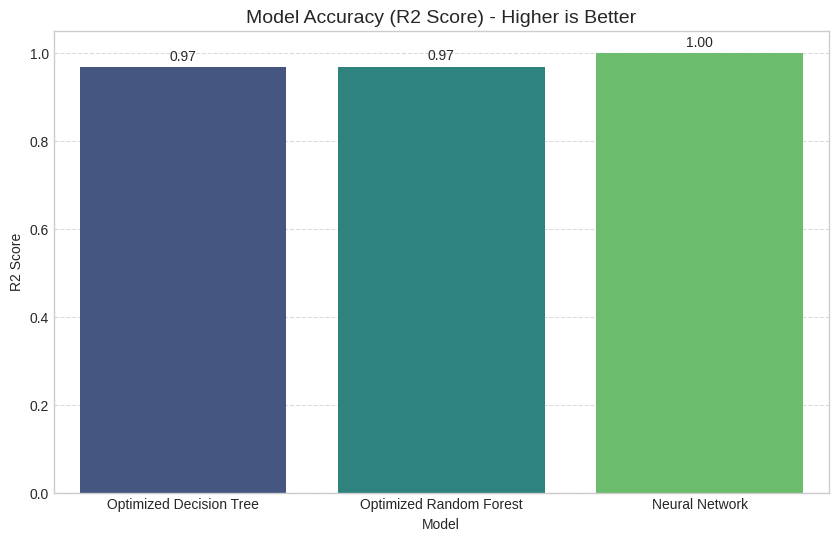

/tmp/ipython-input-1370842256.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Model', y='RMSE', data=df_final, palette='magma')


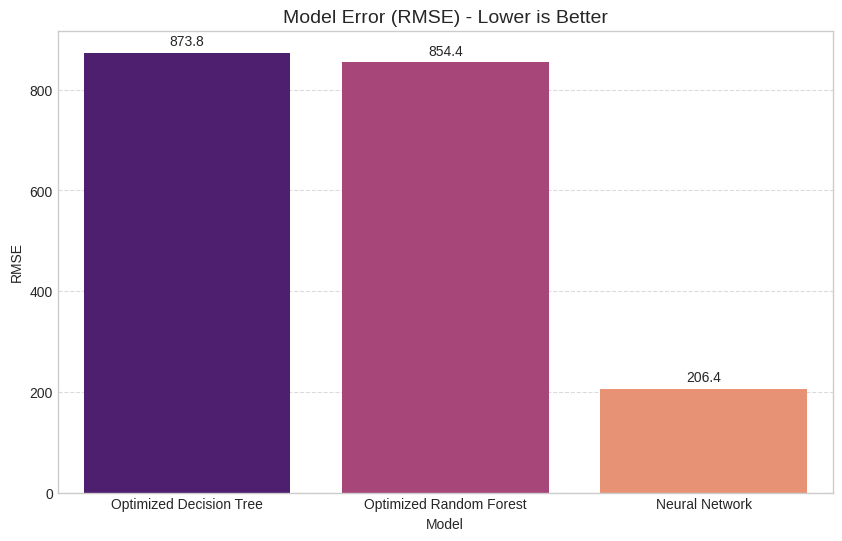

/tmp/ipython-input-1370842256.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(x='Model', y='Time (s)', data=df_final, palette='coolwarm')


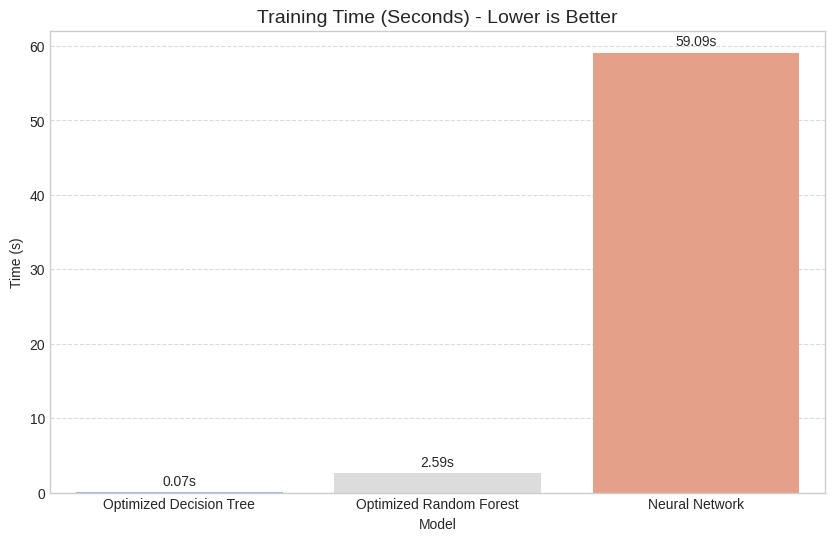

Analysis Complete.


In [18]:
# ==========================================
# 9. Final Comparison & Visuals (Separated Graphs)
# ==========================================

final_results = []

# 1. Final Decision Tree (Optimized + Selected Features)
start = time.time()
final_dt = DecisionTreeRegressor(**best_dt_params, random_state=42)
final_dt.fit(X_train_sel, y_train)
dt_time = time.time() - start
y_pred_dt = final_dt.predict(X_test_sel)

# 2. Final Random Forest (Optimized + Selected Features)
start = time.time()
final_rf = RandomForestRegressor(**best_rf_params, random_state=42)
final_rf.fit(X_train_sel, y_train)
rf_time = time.time() - start
y_pred_rf = final_rf.predict(X_test_sel)

# Compile Results
for name, preds, t in [("Optimized Decision Tree", y_pred_dt, dt_time),
                       ("Optimized Random Forest", y_pred_rf, rf_time)]:
    final_results.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2 Score": r2_score(y_test, preds),
        "Time (s)": t
    })

# Add Neural Network (from Task 1)
final_results.append({
    "Model": "Neural Network",
    "RMSE": nn_rmse,
    "R2 Score": nn_r2,
    "Time (s)": nn_time
})

df_final = pd.DataFrame(final_results)

# Display Table
print("\n--- Final Model Comparison Table ---")
display(df_final.round(4))

# ==========================================
# GRAPH 1: Accuracy (R2 Score)
# ==========================================
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Model', y='R2 Score', data=df_final, palette='viridis')
plt.title('Model Accuracy (R2 Score) - Higher is Better', fontsize=14)
plt.ylabel('R2 Score')
plt.ylim(0, 1.05) # Little extra space at top
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add text labels on bars
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.show()

# ==========================================
# GRAPH 2: Error (RMSE)
# ==========================================
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='Model', y='RMSE', data=df_final, palette='magma')
plt.title('Model Error (RMSE) - Lower is Better', fontsize=14)
plt.ylabel('RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.show()

# ==========================================
# GRAPH 3: Training Time
# ==========================================
plt.figure(figsize=(10, 6))
ax3 = sns.barplot(x='Model', y='Time (s)', data=df_final, palette='coolwarm')
plt.title('Training Time (Seconds) - Lower is Better', fontsize=14)
plt.ylabel('Time (s)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():.2f}s', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.show()

print("Analysis Complete.")
